In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, BatchNormalization, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import os

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/DAEN690/NEW"
filenames = os.listdir(path)

df=pd.DataFrame({'filename':filenames})
df["category"] = df.apply(lambda x: x['filename'].split(' ')[0], axis=1)

temp1 = df[df.category=='china']
temp2 = df[df.category=='usa']
df = pd.concat([temp1, temp2],ignore_index=True, axis = 0)
df.category.value_counts()

train_df, validate_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df["category"])
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42, stratify=validate_df["category"])

#resetting the index
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [5]:
print(train_df.category.value_counts())
print(validate_df.category.value_counts())
print(test_df.category.value_counts())

china    7000
usa      7000
Name: category, dtype: int64
usa      1500
china    1500
Name: category, dtype: int64
usa      1501
china    1500
Name: category, dtype: int64


In [ ]:
cnn= tf.keras.models.Sequential()

#first convolution
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',input_shape=[224,224,3]))
cnn.add(BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

#second convolution layer
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
cnn.add(BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

#third convolution layer
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
cnn.add(BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

#fourth convolution layer
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
cnn.add(BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(Dropout(0.2))

#fully connected layer
cnn.add(tf.keras.layers.Dense(128,activation='relu'))
cnn.add(Dropout(0.5))

#output layer
cnn.add(tf.keras.layers.Dense(units=len(train_df.category.value_counts()),activation='softmax'))

In [6]:
train_datagen = ImageDataGenerator( rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip = True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

train_set = train_datagen.flow_from_dataframe(train_df,path,x_col='filename',y_col='category',
                                              target_size=(224, 224),class_mode='categorical',batch_size=32)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_set = validation_datagen.flow_from_dataframe(validate_df,path,x_col='filename',
                                                        y_col='category',target_size=(224, 224),
                                                        class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_dataframe(test_df,path,x_col='filename',
                                            y_col='category',target_size=(224, 224),
                                            class_mode='categorical',batch_size=32, shuffle=False)

Found 14000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 3001 validated image filenames belonging to 2 classes.


In [ ]:
cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 256)     7168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 222, 222, 256)     1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 256)     0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 111, 111, 256)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 512)     1180160   
_________________________________________________________________
batch_normalization_5 (Batch (None, 109, 109, 512)     2048      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 512)      

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

r = cnn.fit(train_set, 
            validation_data=validation_set,
            epochs=30,
            steps_per_epoch=len(train_set),
            validation_steps=len(validation_set),
            callbacks=callback)

Epoch 1/30
438/438 [==============================] - 7250s 17s/step - loss: 0.9643 - accuracy: 0.5703 - val_loss: 0.7774 - val_accuracy: 0.5597
Epoch 2/30
438/438 [==============================] - 526s 1s/step - loss: 0.6232 - accuracy: 0.6583 - val_loss: 0.5877 - val_accuracy: 0.7057
Epoch 3/30
438/438 [==============================] - 498s 1s/step - loss: 0.5885 - accuracy: 0.6947 - val_loss: 0.6285 - val_accuracy: 0.6577
Epoch 4/30
438/438 [==============================] - 514s 1s/step - loss: 0.5691 - accuracy: 0.7152 - val_loss: 0.5521 - val_accuracy: 0.7350
Epoch 5/30
438/438 [==============================] - 528s 1s/step - loss: 0.5593 - accuracy: 0.7236 - val_loss: 0.5582 - val_accuracy: 0.7337
Epoch 6/30
438/438 [==============================] - 531s 1s/step - loss: 0.5386 - accuracy: 0.7330 - val_loss: 0.5272 - val_accuracy: 0.7470
Epoch 7/30
438/438 [==============================] - 533s 1s/step - loss: 0.5306 - accuracy: 0.7390 - val_loss: 0.5264 - val_accuracy: 0.74

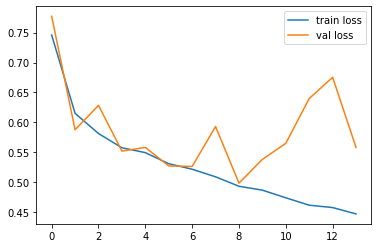

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/DAEN690/CNN_2/CNN_ValLoss_2.png')
plt.show()

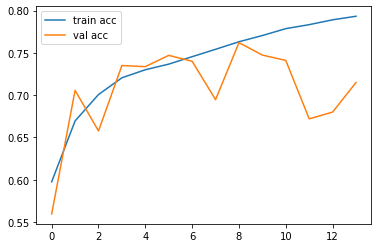

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/DAEN690/CNN_2/CNN_ValACC_2.png')
plt.show()

In [ ]:
cnn.save('/content/drive/MyDrive/Colab Notebooks/DAEN690/CNN_2/CNN_2.h5')

In [7]:
train_set.class_indices.items()

dict_items([('china', 0), ('usa', 1)])

In [8]:
cnn = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/DAEN690/CNN_2/CNN_2.h5')
test_set.reset()
pred = cnn.predict(test_set)
test_df["pred"] = np.argmax(pred, axis=1)
test_df["pred"] = test_df["pred"].replace({0:'china',1:'usa'})
test_df.tail()

,filename,category,pred
2996,usa (8918).jpg,usa,usa
2997,china (467).jpg,china,china
2998,china (1181).jpg,china,china
2999,china (4967).jpg,china,china
3000,usa (5440).jpg,usa,usa


In [9]:
test_df.to_csv("/content/drive/MyDrive/Colab Notebooks/DAEN690/CNN_2/test_df.csv")

In [ ]:
cnn.evaluate(test_set, verbose=2)

94/94 - 72s - loss: 0.4740 - accuracy: 0.7614


[0.4739997982978821, 0.7614128589630127]

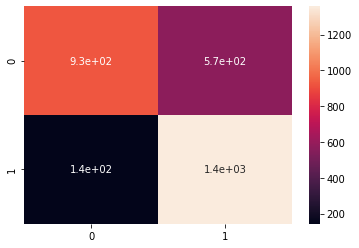

In [ ]:
cm = confusion_matrix(test_df['category'], test_df['pred'])
sns.heatmap(cm, annot=True)

In [10]:
target_names = ['china','usa']
classification_report(test_df['category'], test_df['pred'], target_names= target_names)

'              precision    recall  f1-score   support\n\n       china       0.87      0.62      0.72      1500\n         usa       0.70      0.91      0.79      1501\n\n    accuracy                           0.76      3001\n   macro avg       0.79      0.76      0.76      3001\nweighted avg       0.79      0.76      0.76      3001\n'

In [ ]:
#               precision    recall  f1-score   support

#        china       0.87      0.62      0.72      1500
#          usa       0.70      0.91      0.79      1501

#     accuracy                           0.76      3001
#    macro avg       0.79      0.76      0.76      3001
# weighted avg       0.79      0.76      0.76      3001

In [ ]:
from keras.preprocessing import image

sample_test = test_df.sample(n=35).reset_index(drop=True)
plt.figure(figsize=(20, 20))
for index, row in sample_test.iterrows():
    filename = row['filename']
    pred = row['pred']
    img = image.load_img(path + "/" + filename, target_size=(224,224))
    plt.subplot(5, 7, index+1)
    plt.imshow(img)
    plt.xlabel(filename.split(' ')[0] + '(' + "{}".format(pred) + ')' )
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Image Augmentation
example_df = train_df.sample(n=1).reset_index(drop=True)
example_set = train_datagen.flow_from_dataframe(
    example_df, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_set:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()